This notebook is a simple usage demonstration. If you haven't already, download [the curvesim repository](https://github.com/curveresearch/curvesim), or install it with `pip install curvesim` in a Python virtual environment ([Virtual environment guide](https://realpython.com/python-virtual-environments-a-primer/#create-it)).

Let's assume that we've created a Stableswap pool to provide liquidity for our protocol's stablecoin against other stablecoins. We want to know if we should change pool parameters, which affect liquidity depth, trading volume, and profit, among other metrics.

In [1]:
import sys
sys.path.insert(0, "..") # access curvesim module in /curvesim from /notebooks, where this notebook is
import curvesim
curvesim.__version__

'0.5.0.b2'

Curvesim can automatically simulate pool activity under historical onchain volumes with the `autosim` function. For demonstration, we'll use the 3pool (DAI-USDC-USDT), which has the deepest stablecoin liquidity on Curve. Let's provide lists of `A` and `fee` parameters to predict performance under a wide variety of pool configurations.

In [2]:
pool_address = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool address; use your pool's address if you've deployed one on Curve
A_list = [10, 100, 300, 500, 1000, 2000, 3000, 5000] # pool parameter A from the whitepaper; higher A means a stronger peg, but also a harder depeg if there's too much imbalance
fee_list = [bps * 10**6 for bps in range(1, 4 + 1)] # static swap fee rates; fees have 10**10 precision in Curve contracts; 10**6 precision is 1 basis point, or 0.01% (10**-4)
res = curvesim.autosim(pool_address, A=A_list, fee=fee_list)

[INFO][13:27:12][curvesim.price_data.sources]-8220: Fetching CoinGecko price data...
[INFO][13:27:14][curvesim.pool_data.cache]-8220: Fetching historical volume...
[INFO][13:27:14][curvesim.network.subgraph]-8220: Volume end date: 2023-10-03 00:00:00+00:00
[INFO][13:27:14][curvesim.pipelines.utils]-8220: Volume Multipliers: 
    DAI/USDC: 5.295580887943794e-05
    DAI/USDT: 5.295580887943794e-05
    USDC/USDT: 5.295580887943794e-05
[INFO][13:27:14][curvesim.templates.strategy]-8306: [3Crv] Simulating with {'A': 10, 'fee': 1000000}
[INFO][13:27:14][curvesim.templates.strategy]-8308: [3Crv] Simulating with {'A': 10, 'fee': 3000000}
[INFO][13:27:14][curvesim.templates.strategy]-8312: [3Crv] Simulating with {'A': 100, 'fee': 3000000}
[INFO][13:27:14][curvesim.templates.strategy]-8310: [3Crv] Simulating with {'A': 100, 'fee': 1000000}
[INFO][13:27:29][curvesim.templates.strategy]-8312: [3Crv] Simulating with {'A': 100, 'fee': 4000000}
[INFO][13:27:33][curvesim.templates.strategy]-8310: [3Cr

We can uncomment (Ctrl + /) the cell to below save the results in an html file, but for now, we'll skip that.

In [3]:
# path = "curvesim_demo.html" # if saving in another directory, specify path
# res.plot(save_as=path)

Instead, we'll output the results with "plot". Because the output, containing "summary" and "data" sections, is quite large, let's display only the "summary" section without saving the results using the "save_as" keyword argument. 

In [4]:
res.plot(summary=True, data=False, save_as=None)

/home/phil/.pyenv/versions/curvesim/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/phil/.pyenv/versions/curvesim/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/phil/.pyenv/versions/curvesim/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=Fa

alt.VConcatChart(...)

Above, the `A` values are spread out over the x-axis, and each colored curve corresponds to different `A` values under a static fee value. The plotting library, Vega-Altair, lets you zoom in and out and toggle which points make it on each graph. Clicking an `A` box removes a point from each curve, while clicking a fee box removes the entire curve. Hovering your cursor over a point shows you relevant information at that point.

Our immediate conclusion might be that a higher fee is better after viewing the "Annualized Returns" or "Total Pool Fees" graphs. However, we note that higher fee rates are associated with significantly lower pool volume ("Total Volume"), arbitrage that doesn't stabilize the $1 peg as well ("Price Error"), and, for `A` in [10, 2000], greater pool imbalance ("Pool Balance/Imbalance"), which threatens the peg. 

We also observe in "Total Pool Fees", "Total Volume", and "Annualized Returns (Virtual)", that the optimal `A` seems to be at 1000 or 2000, or maybe in between, for each of the curves representing the 1-3 bps fee tiers.

And now, we plot the remaining "data" section:

In [5]:
res.plot(summary=False, data=True, save_as=None)

/home/phil/.pyenv/versions/curvesim/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.VConcatChart(...)

Each of the colored curves represents an `A` value. By toggling all of the fee boxes at once and zooming in on any graph, we see that each curve becomes a vertical line at every timestamp where curvesim has actual data. These vertical lines contain one point for each of the fee tiers toggled, and we can find them by moving our cursor along the line. 

The "Pool Value" graphs essentially measure the USD value of the entire pool. Among the curves with `A` in [500, 5000], we estimate that there's less than 50 bps of pool value variation on average over time. This variation is negligible compared to the variations in volume or imbalance among the pools.

Let's see if `A` = 1000 or 2000 still appear optimal like we noticed in the "summary" section. For starters, daily volumes ("Daily Volume"), which stabilize the pool's peg through healthy liquidity, are competitive with volumes of most of the other pools. The same goes for the price error distribution ("Price Error"), where we can tell by the overlap in the error distributions. Additionally, the `A` = 1000 and 2000 pools are in the middle in imbalance graph, so if the pool faces a depeg that causes impermanent loss, it will be moderate and easier to recover from. Therefore, 1000 and 2000 are still wise selections for `A`. 

As for the fee, we might consciously keep it low at 1 or 2 bps to better defend the peg. Specifically, that would lower price (arbitrage) error, increase pool volume (liquidity), and decrease imbalance, as the "summary" section indicates. In fact, the real 3pool uses [`A` = 2000 and a fee of 1 basis point](https://curve.fi/#/ethereum/pools/3pool/deposit).

We might wonder: could we test out `A` = 1000 for the 3pool, since it's also optimal? We'll need to "get" the 3pool's parameters and balances using `curvesim.pool.get`. After, we'll plot any price changes caused by instantaneously setting `A` to 1000 with the `bonding_curve` function.

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
pool = curvesim.pool.get(pool_address)
pool.A

2000

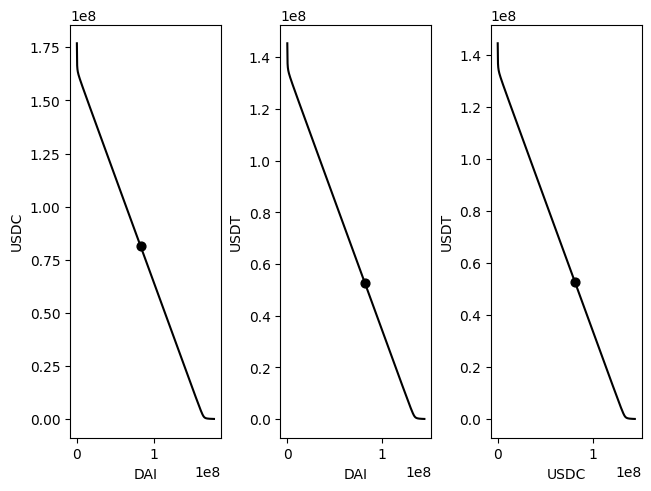

In [7]:
_ = curvesim.bonding_curve(pool, plot=True)

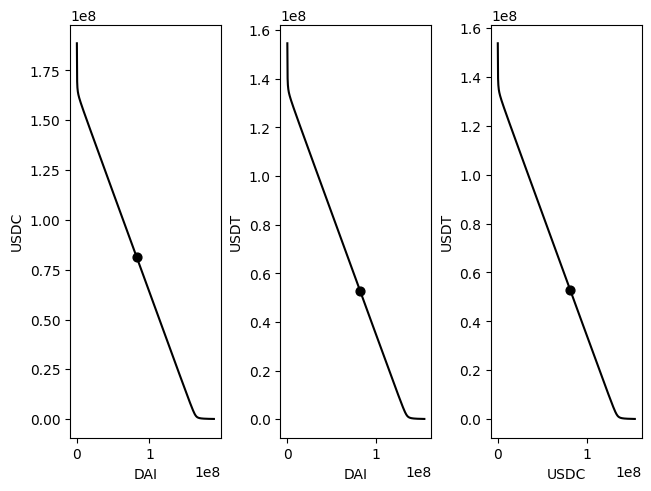

In [8]:
pool.A = 1000
_ = curvesim.bonding_curve(pool, plot=True)

In both cases, the bonding curves' linear slopes allow a ~1:1 exchange rate between each coin pair at depths of several tens of millions of dollars. If `A` = 1000 though, we depeg perhaps a few millions of dollars faster at the edges of each bonding curve.

After such analysis, we may be satisfied with using curvesim, but we may further study the results, which are structured as pandas DataFrames, if we wish to.

In [9]:
import pandas as pd
data_type = type(res.data())
summary_type = type(res.summary())
data_type == summary_type == pd.DataFrame

True

This information should give us enough confidence to set the parameters for our protocol's pool. If you're aiming to unlock more powerful capabilities, I invite you to read the [docs](https://curvesim.readthedocs.io/en/latest/). For example, there's a page that more thoroughly details the ways in which you can [interact with the Python versions of pools](https://curvesim.readthedocs.io/en/latest/api.html) fetched from the blockchain. You can also learn how to customize arbitrageur behavior, sim metrics measured, and pool structure or asset types in the ["Advanced Usage" section](https://curvesim.readthedocs.io/en/latest/advanced.html).

Whatever your mission is, we're glad curvesim could help you. 